# Estimate car price - Apply saved model
This notebook is part of a Machine Learning project that is described and available to download on 
<BR><a href="https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/">https://blogs.sap.com/2019/11/05/hands-on-tutorial-machine-learning-push-down-to-sap-hana-with-python/</a>
<BR><BR>The purpose of this notebook is to apply a trained Machine Learning model to predict a car's price.

### Steps in this notebook
-  Connect to SAP HANA
-  Load the trained model from SAP HANA
-  Create a SAP HANA DataFrame which points to the data that is to be used for a prediction
-  Apply the model that has been loaded on the data and predict the prices

### Documentation
-  SAP HANA Python Client API for Machine Learning Algorithms:   
   https://help.sap.com/doc/0172e3957b5946da85d3fde85ee8f33d/latest/en-US/html/hana_ml.html
-  SAP HANA Predictive Analysis Library (PAL):  
   https://help.sap.com/viewer/2cfbc5cf2bc14f028cfbe2a2bba60a50/latest/en-US/f652a8186a144e929a1ade7a3cb7abe8.html
-  Dataset: https://www.kaggle.com/bozungu/ebay-used-car-sales-data

### Create a SAP HANA DataFrame, which points to the training data
Instantiate a connecton object to SAP HANA.
-  For simplicity, to help you get started, these values are hardcoded here. 
-  We recommend keeping these credentials in the Secure User Store of the SAP HANA Client. Retrieving the credentials from the Secure User Store prevents having to specify these credentials in clear text. See the blog on the SAP Commmunity to which these notebooks belong, for steps on how to use that Secure User Store.

In [1]:
import hana_ml.dataframe as dataframe
conn = dataframe.ConnectionContext(userkey = 'hana_hxe', encrypt = 'true', sslValidateCertificate = 'false')

### Load model
Load the trained model from SAP HANA.

In [2]:
from hana_ml.model_storage import ModelStorage
model_storage = ModelStorage(connection_context = conn)
tree_reg_saved = model_storage.load_model(name = 'USEDCARPRICES_MODEL_REGTREE', version = 1)

### Predict price of "new" cars
Create a SAP HANA DataFrame, which points to the table that contains the cars for which the prices are to be predicted. No data is extracted.

In [3]:
df_remote_new = conn.table(table = 'USEDCARPRICES_TOPREDICT')

Peak at the cars that are to be predicted.

In [4]:
df_remote_new.head(3).collect()

,CAR_ID,VEHICLETYPE,YEAR,GEARBOX,HP,MODEL,KILOMETER,FUELTYPE
0,1,coupe,2006,manual,231,CLK,50000,petrol
1,2,coupe,2006,manual,231,CLK,150000,petrol


Apply the trained model on the cars to estimate the price.

In [5]:
features = ['VEHICLETYPE', 'YEAR', 'MODEL', 'HP', 'FUELTYPE', 'KILOMETER', 'GEARBOX']
df_remote_predict = tree_reg_saved.predict(data = df_remote_new,
                                           features = features, 
                                           key = 'CAR_ID').select('CAR_ID', 'SCORE')
df_predict = df_remote_predict.collect()
df_predict

,CAR_ID,SCORE
0,1,17081.6
1,2,12066.8


Compare the two prices in a bar chart.

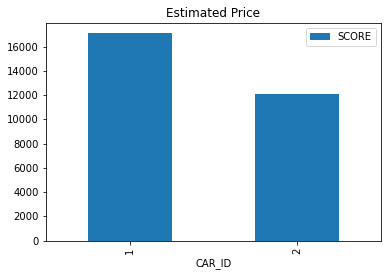

In [6]:
%matplotlib inline
import pandas as pd
df_predict['SCORE'] = pd.to_numeric(df_predict['SCORE'])
df_predict['CAR_ID'] = df_predict['CAR_ID'].astype(str)
df_predict.plot.bar(x = 'CAR_ID', y = 'SCORE', title = 'Estimated Price');

Remember that both cars are identical apart from their mileage. The car that has driven an additional 100.000 kilometers is worth over 4.000 Euros less. We are satisfied with the preditions and persist them in a SAP HANA table.

In [7]:
df_remote_result = df_remote_predict.save(where = 'USEDCARPRICES_PREDICTED', 
                                          table_type = 'COLUMN', 
                                          force = True)

### Close connection

In [8]:
conn.close()

### Summary

By going through the notebooks of this project you now have an understanding of how a Data Scientist can leverage SAP HANA directly out of Python. Without having to extract data from SAP HANA, the data can be explored and imputed. Machine Learning models can be trained, tuned and analysed. Predictions can be carried out, visualised and persisted as SAP HANA table. 
<BR><BR>Consider using SAP Data Intelligence to deploy the Python code into an ongoing productive process, which can retrain the model and provide predictions in real-time. As the calculations were pushed down to SAP HANA, the code in the Notebooks is also a documentation of the different Data Science steps. As all steps are transparent, it become easier for IT to deploy the code into an ongoing process under corporate governance.